In [1]:
import pandas as pd
import numpy as np
import os
import CRPS.CRPS as pscore
import copy
from joblib import dump, load
from time import sleep
from tqdm import tqdm
import warnings
from sklearn.feature_selection import VarianceThreshold
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import statsmodels.api as sm # recommended import according to the docs
import matplotlib.pyplot as plt


def check_Actuals(country_id, dataindex):
    # Check if the country_id exists in actual dataset
    if country_id not in country_actual_group_list[dataindex].groups.keys():
        return False
    else:
        return True

# check if the last month of a country in the feature dataset is 3 months before the first month that has to be predicted
def check_last_featureMonth(country_id, dataindex):
    # Check if the country_id exists in actual dataset
    if country_id not in country_actual_group_list[dataindex].groups.keys():
        raise ValueError('country does not have actuals')


    # last month of the feature dataset
    last_feature_month = country_feature_group_list[dataindex].get_group(country_id).index.get_level_values('month_id').unique().tolist()[-1]

    # first month of the actual dataset
    first_actual_month = country_actual_group_list[dataindex].get_group(country_id).index.get_level_values('month_id').unique().tolist()[0]

    # if the last month of the feature dataset in the country does not match the first of the actuals return false
    if (first_actual_month - 3) != last_feature_month:
        return False
    else:
        return True


# create the feature- and actuals-data list
# set the feature and actuals year lists
feature_years = ['2017','2018','2019','2020','2021','2022']
actual_years = ['2018','2019','2020','2021','2022','2023']

actuals_df_list = []
features_df_list = []

# path to the current directory
current_dir = os.getcwd()

# read feature dataset
relative_path_features = os.path.join('..', 'data', 'cm_features.parquet')
path_features = os.path.join(current_dir, relative_path_features)
feature_data = pd.read_parquet(path_features, engine='pyarrow')

for i in range(len(feature_years)):
    # relative paths to the parquet files
    relative_path_actuals = os.path.join('..', 'data', 'cm_actuals_' + actual_years[i] + '.parquet')
    path_actuals = os.path.join(current_dir, relative_path_actuals)

    feature_data_toOct = feature_data[feature_data['month_id'] <= 454 + (i * 12)]
    feature_data_toOct.set_index(['month_id', 'country_id'], inplace=True)

    # append datasets to the lists
    actuals_df_list.append({'year':actual_years[i], 'data':pd.read_parquet(path_actuals, engine='pyarrow')})
    features_df_list.append({'year':feature_years[i], 'data':feature_data_toOct})

# country group list of all years
country_feature_group_list = []
country_actual_group_list = []

# fill list 
for i in range(len(features_df_list)):
    country_feature_group_list.append(features_df_list[i]['data'].groupby('country_id'))
    country_actual_group_list.append(actuals_df_list[i]['data'].groupby('country_id'))


data = features_df_list[-1]['data']
if 'gleditsch_ward' in data.columns:
    data = data.drop(columns='gleditsch_ward') # column not necessary

## Features without missing values
columns_without_missing_values = data.columns[data.notna().all()]

for i in range(len(features_df_list)):
    data_set = features_df_list[i]['data']
    features_df_list[i]['data'] = data_set[columns_without_missing_values]

# last dataset contains all other datasets
all_features = features_df_list[-1]['data'].columns

relative_path_countrylist = os.path.join('..', 'data', 'country_list.csv')
path_countrylist = os.path.join(current_dir, relative_path_countrylist)

# CSV of the countries
countryList_prediction = pd.read_csv(path_countrylist)
country_list = countryList_prediction.loc[:,'country_id'].values.tolist() 

# concat all actual month ged_sb for each country
actuals_df_concat = pd.DataFrame()

for i in range(1,len(actuals_df_list)):
    if i == 1:
        actuals_df_concat = pd.concat([actuals_df_list[i-1]['data'], actuals_df_list[i]['data']])
    else:
        actuals_df_concat = pd.concat([actuals_df_concat, actuals_df_list[i]['data']])

actuals_df_concat_group = actuals_df_concat.groupby('country_id')


In [2]:
import pandas as pd
from joblib import load
import numpy as np

user_dir = os.path.expanduser('~')

prediction_data_list = []

for year in actual_years:
    # conflictology
    parquet_file_path = os.path.join(user_dir, 'iCloudDrive\\VIEWS Joblib Predicitons\\VIEWS benchmark', 'bm_conflictology_cm_' + year + '.parquet')
    benchmark_data_conflict = pd.read_parquet(parquet_file_path)

    # last pois
    parquet_file_path = os.path.join(user_dir, 'iCloudDrive\\VIEWS Joblib Predicitons\\VIEWS benchmark', 'bm_last_cm_' + year + '.parquet')
    benchmark_data_pois = pd.read_parquet(parquet_file_path)

    # nbinom
    parquet_file_path = os.path.join(user_dir, 'iCloudDrive\\VIEWS Joblib Predicitons\\Baseline', 'cm_nbinom_test_window_' + year + '.parquet')
    baseline_nbinom_data = pd.read_parquet(parquet_file_path)

    # hurdle
    parquet_file_path = os.path.join(user_dir, 'iCloudDrive\\VIEWS Joblib Predicitons\\Baseline', 'cm_hurdle_test_window_' + year + '.parquet')
    baseline_hurdle_data = pd.read_parquet(parquet_file_path)

    # neural net
    parquet_file_path = os.path.join(user_dir, 'iCloudDrive\\VIEWS Joblib Predicitons\\Neural Net\\Predictions', 'cm_NN_notrap_test_window_' + year + '.parquet')
    nn_data = pd.read_parquet(parquet_file_path)

    prediction_data_list.append({'bmConflict':benchmark_data_conflict,
                                 'bmLastPois':benchmark_data_pois,
                                 'NB':baseline_nbinom_data,
                                 'Hurdle':baseline_hurdle_data,
                                 'NN':nn_data
                                 })

In [3]:
import numpy as np
from collections import Counter

bins = [
        0,
        0.5,
        2.5,
        5.5,
        10.5,
        25.5,
        50.5,
        100.5,
        250.5,
        500.5,
        1000.5,
    ]

def _ensemble_ignorance_score(predictions, n, observed):
        c = Counter(predictions)
        # n = c.total() : this works from python version 3.10, avoid this for a while.
        prob = c[observed] / n # if counter[observed] is 0, then this returns correctly
        return -np.log2(prob)

def ensemble_ignorance_score(observations, forecasts, bins, low_bin = 0, high_bin = 10000):
    """
    This implements the Ensemble (Ranked) interval Score from the easyVerification R-package in Python. Also inspired by properscoring.crps_ensemble(),
    and has interface that works with the xskillscore package.

    Parameters
    ----------
    observations : float or array_like
        Observations float or array. Missing values (NaN) are given scores of
        NaN.
    forecasts : float or array_like
        Array of forecasts ensemble members, of the same shape as observations
        except for the axis along which RIGN is calculated (which should be the
        axis corresponding to the ensemble). If forecasts has the same shape as
        observations, the forecasts are treated as deterministic. Missing
        values (NaN) are ignored.
    round_values: converts input data to integers by rounding.
    

    Returns
    -------
    out : np.ndarray
        RIGN for each ensemble forecast against the observations.
    """
    observations = np.asarray(observations)
    forecasts = np.asarray(forecasts)

    assert np.all(forecasts >= 0), f"Forecasts must be non-negative."
    assert np.all(observations >= 0), f"Observations must be non-negative."

    assert isinstance(bins, (int, list)), f"bins must be an integer or a list with floats"
    if isinstance(bins, int):
        assert bins > 0, f"bins must be an integer above 0 or a list with floats."

    def digitize_minus_one(x, bins, right=False):
        return np.digitize(x, bins, right) - 1

    """ edges = np.histogram_bin_edges(forecasts[..., :], bins = bins, range = (low_bin, high_bin))
    binned_forecasts =  np.apply_along_axis(digitize_minus_one, axis = 1, arr = forecasts, bins = edges)
    binned_observations = digitize_minus_one(observations, edges) """

    edges = np.histogram_bin_edges(forecasts, bins=bins, range=(low_bin, high_bin))
    binned_forecasts = digitize_minus_one(forecasts, edges)
    binned_observations = digitize_minus_one(observations, edges)


    # Append one observation in each bin-category to the forecasts to prevent 0 probability occuring.
    unique_categories = np.arange(0, len(bins))
    binned_forecasts = np.concatenate((binned_forecasts, np.tile(unique_categories, binned_forecasts.shape[:-1] + (1,))), axis = -1)
    
    n = binned_forecasts.shape[-1]

    #if observations.shape == forecasts.shape:
        # exact prediction yields 0 ign
    ign_score = np.empty_like(binned_observations, dtype = float)
    for index in np.ndindex(ign_score.shape):
        ign_score[index] = _ensemble_ignorance_score(binned_forecasts[index], n, binned_observations[index])
    
    
    return ign_score

def interval_score(observed: np.array, predictions: np.array, prediction_interval_level: float = 0.90) -> np.array:
    """
    Interval Score implemented based on the scaled Mean Interval Score in the R tsRNN package https://rdrr.io/github/thfuchs/tsRNN/src/R/metrics_dist.R

    The Interval Score is a probabilistic prediction evaluation metric that weights between the narrowness of the forecast range and the ability to correctly hit the observed value within that interval.
    
    :param observed: observed values
    :type observed: array_like
    :param predictions: probabilistic predictions with the latter axis (-1) being the forecasts for each observed value
    :type predictions: array_like
    :param prediction_interval_level: prediction interval between [0, 1]
    :type prediction_interval_level: float
    :returns array_like with the interval score for each observed value
    :rtype array_like

    observed = np.random.negative_binomial(5, 0.8, size = 600)
    forecasts = np.random.negative_binomial(5, 0.8, size = (600, 1000))

    score = interval_score(observed, forecasts)
    print(f'MIS: {score.mean()}')

    """

    assert 0 < prediction_interval_level < 1, f"'prediction_interval_level' must be a number between 0 and 1." 

    alpha = 1 - prediction_interval_level
    lower = np.quantile(predictions, q = alpha/2, axis = -1)
    upper = np.quantile(predictions, q = 1 - (alpha/2), axis = -1)

    interval_width = upper - lower
    lower_coverage = (2/alpha)*(lower-observed) * (observed<lower)
    upper_coverage = (2/alpha)*(observed-upper) * (observed>upper)

    return(interval_width + lower_coverage + upper_coverage)

In [4]:
warnings.filterwarnings("ignore")

s_prediction_list = list(range(3, 15))

month_list_plot = []
ignorance_last_poisson = []
ignorance_conflictology = []
ignorance_nb_baseline = []
ignorance_hurdle_baseline = []
ignorance_nn = []

for year in tqdm(actual_years):
    dataset_index = actual_years.index(year)

    last_poisson_data = prediction_data_list[dataset_index]['bmLastPois']
    conflictology_data = prediction_data_list[dataset_index]['bmConflict']
    nb_baseline_data = prediction_data_list[dataset_index]['NB']
    hurdle_baseline_data = prediction_data_list[dataset_index]['Hurdle']
    nn_data = prediction_data_list[dataset_index]['NN']

    actual_data = actuals_df_list[dataset_index]['data']
    actual_group = actual_data.groupby('country_id')

    for s in s_prediction_list:
        
        mean_ignorance_last_poisson = []
        mean_ignorance_conflictology = []
        mean_ignorance_nb_baseline = []
        mean_ignorance_hurdle_baseline = []
        mean_ignorance_nn_empirical = []

        for country in country_list:

            prediction_month = actual_data.index.get_level_values('month_id').unique().to_list()[s-3]
            y_true = actual_group.get_group(country).iloc[s-3,0]
            
            last_poisson_empirical_distribution = last_poisson_data.loc[(prediction_month,country),:].values.flatten()
            conflictology_empirical_distribution = conflictology_data.loc[(prediction_month,country),:].values.flatten()
            nb_baseline_empirical_distribution = nb_baseline_data.loc[(prediction_month,country),:].values.flatten()
            hurdle_baseline_empirical_distribution = hurdle_baseline_data.loc[(prediction_month,country),:].values.flatten()
            nn_empirical_distribution = nn_data.loc[(prediction_month,country),:].values.flatten()

            mean_ignorance_last_poisson.append(ensemble_ignorance_score(y_true, last_poisson_empirical_distribution, bins) + 0)
            mean_ignorance_conflictology.append(ensemble_ignorance_score(y_true, conflictology_empirical_distribution, bins) + 0)
            mean_ignorance_nb_baseline.append(ensemble_ignorance_score(y_true, nb_baseline_empirical_distribution, bins) + 0)
            mean_ignorance_hurdle_baseline.append(ensemble_ignorance_score(y_true, hurdle_baseline_empirical_distribution, bins) + 0)
            mean_ignorance_nn_empirical.append(ensemble_ignorance_score(y_true, nn_empirical_distribution, bins) + 0)

        month_list_plot.append(prediction_month)
        ignorance_last_poisson.append(np.mean(mean_ignorance_last_poisson))
        ignorance_conflictology.append(np.mean(mean_ignorance_conflictology))
        ignorance_nb_baseline.append(np.mean(mean_ignorance_nb_baseline))
        ignorance_hurdle_baseline.append(np.mean(mean_ignorance_hurdle_baseline))
        ignorance_nn.append(np.mean(mean_ignorance_nn_empirical))

100%|██████████| 6/6 [09:38<00:00, 96.36s/it]


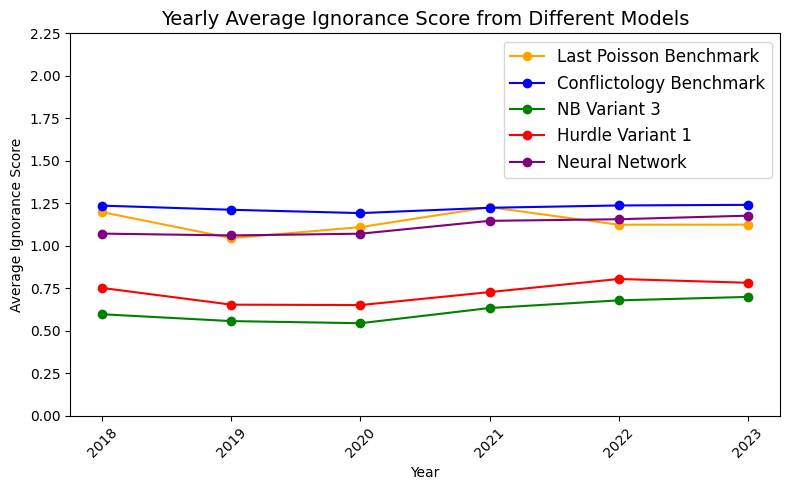

In [5]:
ignorance_by_year = {
    '2018': [],
    '2019': [],
    '2020': [],
    '2021': [],
    '2022': [],
    '2023': []
}

Keys_ignorance_by_year = list(ignorance_by_year.keys())
index_list = [[0,12], [12,24], [24,36], [36,48], [48,60], [60,72]]

for i in range(len(ignorance_by_year)):
    ignorance_by_year[Keys_ignorance_by_year[i]].append(np.mean(ignorance_last_poisson[index_list[i][0]:index_list[i][1]]))
    ignorance_by_year[Keys_ignorance_by_year[i]].append(np.mean(ignorance_conflictology[index_list[i][0]:index_list[i][1]]))
    ignorance_by_year[Keys_ignorance_by_year[i]].append(np.mean(ignorance_nb_baseline[index_list[i][0]:index_list[i][1]]))
    ignorance_by_year[Keys_ignorance_by_year[i]].append(np.mean(ignorance_hurdle_baseline[index_list[i][0]:index_list[i][1]]))
    ignorance_by_year[Keys_ignorance_by_year[i]].append(np.mean(ignorance_nn[index_list[i][0]:index_list[i][1]]))

import matplotlib.pyplot as plt

# Daten
methoden = [
    'Last Poisson Benchmark',
    'Conflictology Benchmark',
    'NB Variant 3',
    'Hurdle Variant 1',
    'Neural Network'
]

# Plot erstellen
plt.figure(figsize=(8, 5))

colors = ['orange','blue','green','red','purple']

# Für jede Methode eine Linie zeichnen
for i, methode in enumerate(methoden):
    plt.plot(ignorance_by_year.keys(), [ignorance_by_year[jahr][i] for jahr in ignorance_by_year.keys()], marker='o', label=methode, color=colors[i])

# Titel und Achsenbeschriftungen
plt.title('Yearly Average Ignorance Score from Different Models', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Average Ignorance Score')

# Legende hinzufügen
plt.legend(fontsize=12, loc='upper right') #loc='center left', bbox_to_anchor=(1, 0.5)

plt.ylim(0, 2.25)

# Diagramm anzeigen
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [6]:
print('2018:' + str(ignorance_by_year['2018']))
print('2019:' + str(ignorance_by_year['2019']))
print('2020:' + str(ignorance_by_year['2020']))
print('2021:' + str(ignorance_by_year['2021']))
print('2022:' + str(ignorance_by_year['2022']))
print('2023:' + str(ignorance_by_year['2023']))

2018:[1.1984386527497586, 1.236654943411027, 0.5977998731983977, 0.7523731813508481, 1.0720172157883787]
2019:[1.0455847753930538, 1.2122875285663108, 0.5575688227305283, 0.6542500072475436, 1.0613690647241845]
2020:[1.110315744285602, 1.1927439973322103, 0.5450961405181582, 0.6518382582621173, 1.0715660737003947]
2021:[1.2277811476419214, 1.2240740612630308, 0.6344284540702777, 0.7280485174020024, 1.1471898261428648]
2022:[1.1244286344687746, 1.2376504994141895, 0.6794421961015488, 0.8053377206108233, 1.1566749986681077]
2023:[1.1246988522265526, 1.2412796110939686, 0.6998117085026294, 0.7829392138912848, 1.1775389712902167]
